In [1]:
# !pip install nes-py==0.2.6
# !pip install gym-super-mario-bros
# !apt-get update
# !apt-get install ffmpeg libsm6 libxext6  -y
# !apt install -y libgl1-mesa-glx
# !pip install opencv-python

In [2]:
import torch
import torch.nn as nn
import random
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt

/Users/varadhkaushik/Desktop/NEU/CS_5100-Foundations_of_AI/Projects/RL-models-for-Super-Mario-Bros/mario-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

In [4]:
class DQNSolver(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    

class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dq, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dq = double_dq
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if self.double_dq:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("dq1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("dq2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        else:  
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("dq.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("ddqn-files/STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ddqn-files/ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("ddqn-files/REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("ddqn-files/STATE2_MEM.pt")
            self.DONE_MEM = torch.load("ddqn-files/DONE_MEM.pt")
            with open("ddqn-files/ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("ddqn-files/num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
        
    def recall(self):
        # Randomly sample 'batch size' experiences
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]
        
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        # Epsilon-greedy action
        
        if self.double_dq:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dq:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def copy_model(self):
        # Copy local net weights into target net
        
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        
        if self.double_dq and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dq:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * 
                                        self.target_net(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * 
                                        self.dqn(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

In [5]:
def vectorize_action(action, action_space):
    # Given a scalar action, return a one-hot encoded action
    
    return [0 for _ in range(action)] + [1] + [0 for _ in range(action + 1, action_space)]

In [6]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/q0/g96dqwx93hlcknys_x3xcgr80000gn/T/ipykernel_98578/384838081.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  state = torch.Tensor([state])
  1%|          | 1/100 [00:01<01:44,  1.06s/it]

Total reward after episode 1 is 237.0


  2%|▏         | 2/100 [00:03<03:24,  2.08s/it]

Total reward after episode 2 is 246.0


  3%|▎         | 3/100 [00:06<04:08,  2.56s/it]

Total reward after episode 3 is 248.0


  4%|▍         | 4/100 [00:12<05:49,  3.64s/it]

Total reward after episode 4 is 628.0


  5%|▌         | 5/100 [00:14<04:45,  3.01s/it]

Total reward after episode 5 is 248.0


  6%|▌         | 6/100 [00:24<08:29,  5.42s/it]

Total reward after episode 6 is 600.0


  7%|▋         | 7/100 [00:26<07:00,  4.52s/it]

Total reward after episode 7 is 249.0


  8%|▊         | 8/100 [00:29<05:48,  3.78s/it]

Total reward after episode 8 is 249.0


  9%|▉         | 9/100 [00:31<04:55,  3.24s/it]

Total reward after episode 9 is 247.0


 10%|█         | 10/100 [00:33<04:19,  2.88s/it]

Total reward after episode 10 is 248.0


 11%|█         | 11/100 [00:35<03:49,  2.58s/it]

Total reward after episode 11 is 248.0


 12%|█▏        | 12/100 [00:37<03:30,  2.39s/it]

Total reward after episode 12 is 248.0


 13%|█▎        | 13/100 [00:39<03:17,  2.27s/it]

Total reward after episode 13 is 247.0


 14%|█▍        | 14/100 [00:41<03:08,  2.19s/it]

Total reward after episode 14 is 251.0


 15%|█▌        | 15/100 [00:42<02:56,  2.08s/it]

Total reward after episode 15 is 248.0


 16%|█▌        | 16/100 [00:44<02:53,  2.06s/it]

Total reward after episode 16 is 251.0


 17%|█▋        | 17/100 [00:47<02:54,  2.10s/it]

Total reward after episode 17 is 248.0


 18%|█▊        | 18/100 [00:49<02:47,  2.04s/it]

Total reward after episode 18 is 250.0


 19%|█▉        | 19/100 [00:51<02:43,  2.01s/it]

Total reward after episode 19 is 252.0


 20%|██        | 20/100 [00:53<02:40,  2.01s/it]

Total reward after episode 20 is 251.0


 21%|██        | 21/100 [00:55<02:39,  2.02s/it]

Total reward after episode 21 is 248.0


 22%|██▏       | 22/100 [00:56<02:35,  2.00s/it]

Total reward after episode 22 is 251.0


 23%|██▎       | 23/100 [00:59<02:34,  2.00s/it]

Total reward after episode 23 is 248.0


 24%|██▍       | 24/100 [01:01<02:34,  2.03s/it]

Total reward after episode 24 is 252.0


 25%|██▌       | 25/100 [01:38<15:48, 12.65s/it]

Total reward after episode 25 is 1272.0


 26%|██▌       | 26/100 [01:54<16:49, 13.64s/it]

Total reward after episode 26 is 597.0


 27%|██▋       | 27/100 [01:59<13:37, 11.20s/it]

Total reward after episode 27 is 626.0


 28%|██▊       | 28/100 [02:27<19:27, 16.22s/it]

Total reward after episode 28 is 996.0


 29%|██▉       | 29/100 [02:33<15:26, 13.04s/it]

Total reward after episode 29 is 624.0


 30%|███       | 30/100 [02:35<11:23,  9.76s/it]

Total reward after episode 30 is 249.0


 31%|███       | 31/100 [02:40<09:38,  8.39s/it]

Total reward after episode 31 is 635.0


 32%|███▏      | 32/100 [02:50<09:54,  8.74s/it]

Total reward after episode 32 is 598.0


 33%|███▎      | 33/100 [03:01<10:30,  9.41s/it]

Total reward after episode 33 is 750.0


 34%|███▍      | 34/100 [03:03<08:06,  7.36s/it]

Total reward after episode 34 is 235.0


 35%|███▌      | 35/100 [03:06<06:25,  5.93s/it]

Total reward after episode 35 is 248.0


 36%|███▌      | 36/100 [03:16<07:45,  7.28s/it]

Total reward after episode 36 is 818.0


 37%|███▋      | 37/100 [03:28<08:51,  8.43s/it]

Total reward after episode 37 is 771.0


 38%|███▊      | 38/100 [03:49<12:40, 12.27s/it]

Total reward after episode 38 is 730.0


 39%|███▉      | 39/100 [04:06<14:02, 13.82s/it]

Total reward after episode 39 is 745.0


 40%|████      | 40/100 [04:24<15:04, 15.08s/it]

Total reward after episode 40 is 749.0


 41%|████      | 41/100 [04:39<14:45, 15.02s/it]

Total reward after episode 41 is 1582.0


 42%|████▏     | 42/100 [04:50<13:17, 13.76s/it]

Total reward after episode 42 is 1045.0


 43%|████▎     | 43/100 [04:53<10:01, 10.55s/it]

Total reward after episode 43 is 221.0


 44%|████▍     | 44/100 [05:05<10:08, 10.86s/it]

Total reward after episode 44 is 601.0


 45%|████▌     | 45/100 [05:19<10:55, 11.92s/it]

Total reward after episode 45 is 1036.0


 46%|████▌     | 46/100 [05:29<10:07, 11.24s/it]

Total reward after episode 46 is 775.0


 47%|████▋     | 47/100 [05:34<08:20,  9.44s/it]

Total reward after episode 47 is 654.0


 48%|████▊     | 48/100 [05:39<07:06,  8.21s/it]

Total reward after episode 48 is 623.0


 49%|████▉     | 49/100 [05:47<06:56,  8.18s/it]

Total reward after episode 49 is 620.0


 50%|█████     | 50/100 [06:05<09:08, 10.98s/it]

Total reward after episode 50 is 1027.0


 51%|█████     | 51/100 [06:25<11:17, 13.83s/it]

Total reward after episode 51 is 790.0


 52%|█████▏    | 52/100 [06:31<09:02, 11.29s/it]

Total reward after episode 52 is 623.0


 53%|█████▎    | 53/100 [06:35<07:16,  9.28s/it]

Total reward after episode 53 is 606.0


 54%|█████▍    | 54/100 [06:39<05:45,  7.51s/it]

Total reward after episode 54 is 237.0


 55%|█████▌    | 55/100 [06:44<05:12,  6.94s/it]

Total reward after episode 55 is 617.0


 56%|█████▌    | 56/100 [06:55<06:00,  8.19s/it]

Total reward after episode 56 is 1348.0


 57%|█████▋    | 57/100 [07:08<06:54,  9.65s/it]

Total reward after episode 57 is 1434.0


 58%|█████▊    | 58/100 [07:14<05:55,  8.47s/it]

Total reward after episode 58 is 653.0


 59%|█████▉    | 59/100 [07:25<06:15,  9.16s/it]

Total reward after episode 59 is 1324.0


 60%|██████    | 60/100 [07:36<06:23,  9.59s/it]

Total reward after episode 60 is 1325.0


 61%|██████    | 61/100 [07:41<05:25,  8.34s/it]

Total reward after episode 61 is 621.0


 62%|██████▏   | 62/100 [07:45<04:32,  7.17s/it]

Total reward after episode 62 is 606.0


 63%|██████▎   | 63/100 [08:01<05:54,  9.58s/it]

Total reward after episode 63 is 586.0


 64%|██████▍   | 64/100 [08:13<06:11, 10.33s/it]

Total reward after episode 64 is 818.0


 65%|██████▌   | 65/100 [08:19<05:15,  9.01s/it]

Total reward after episode 65 is 623.0


 66%|██████▌   | 66/100 [08:24<04:34,  8.07s/it]

Total reward after episode 66 is 605.0


 67%|██████▋   | 67/100 [08:55<08:11, 14.90s/it]

Total reward after episode 67 is 763.0


 68%|██████▊   | 68/100 [08:58<05:56, 11.14s/it]

Total reward after episode 68 is 239.0


 69%|██████▉   | 69/100 [09:24<08:04, 15.61s/it]

Total reward after episode 69 is 1306.0


 70%|███████   | 70/100 [09:30<06:25, 12.85s/it]

Total reward after episode 70 is 624.0


 71%|███████   | 71/100 [09:35<05:05, 10.54s/it]

Total reward after episode 71 is 618.0


 72%|███████▏  | 72/100 [09:41<04:12,  9.01s/it]

Total reward after episode 72 is 631.0


 73%|███████▎  | 73/100 [09:46<03:30,  7.81s/it]

Total reward after episode 73 is 616.0


 74%|███████▍  | 74/100 [10:00<04:15,  9.83s/it]

Total reward after episode 74 is 1578.0


 75%|███████▌  | 75/100 [10:20<05:17, 12.72s/it]

Total reward after episode 75 is 1907.0


 76%|███████▌  | 76/100 [10:33<05:05, 12.75s/it]

Total reward after episode 76 is 773.0


 77%|███████▋  | 77/100 [10:45<04:53, 12.78s/it]

Total reward after episode 77 is 780.0


 78%|███████▊  | 78/100 [10:48<03:34,  9.73s/it]

Total reward after episode 78 is 242.0


 79%|███████▉  | 79/100 [10:56<03:12,  9.14s/it]

Total reward after episode 79 is 598.0


 80%|████████  | 80/100 [11:09<03:27, 10.39s/it]

Total reward after episode 80 is 735.0


 81%|████████  | 81/100 [11:26<03:51, 12.20s/it]

Total reward after episode 81 is 1031.0


 82%|████████▏ | 82/100 [11:28<02:46,  9.27s/it]

Total reward after episode 82 is 240.0


 83%|████████▎ | 83/100 [11:40<02:53, 10.21s/it]

Total reward after episode 83 is 811.0


 84%|████████▍ | 84/100 [11:54<02:59, 11.24s/it]

Total reward after episode 84 is 1580.0


 85%|████████▌ | 85/100 [12:05<02:46, 11.11s/it]

Total reward after episode 85 is 768.0


 86%|████████▌ | 86/100 [12:14<02:28, 10.60s/it]

Total reward after episode 86 is 818.0


 87%|████████▋ | 87/100 [12:25<02:17, 10.60s/it]

Total reward after episode 87 is 1044.0


 88%|████████▊ | 88/100 [12:34<02:02, 10.22s/it]

Total reward after episode 88 is 819.0


 89%|████████▉ | 89/100 [12:47<02:00, 11.00s/it]

Total reward after episode 89 is 1432.0


 90%|█████████ | 90/100 [12:49<01:24,  8.43s/it]

Total reward after episode 90 is 238.0


 91%|█████████ | 91/100 [13:05<01:35, 10.64s/it]

Total reward after episode 91 is 766.0


 92%|█████████▏| 92/100 [13:16<01:26, 10.82s/it]

Total reward after episode 92 is 814.0


 93%|█████████▎| 93/100 [13:22<01:03,  9.09s/it]

Total reward after episode 93 is 623.0


 94%|█████████▍| 94/100 [13:36<01:05, 10.86s/it]

Total reward after episode 94 is 1134.0


 95%|█████████▌| 95/100 [13:50<00:57, 11.55s/it]

Total reward after episode 95 is 1138.0


 96%|█████████▌| 96/100 [14:01<00:45, 11.38s/it]

Total reward after episode 96 is 1437.0


 97%|█████████▋| 97/100 [14:17<00:39, 13.02s/it]

Total reward after episode 97 is 1857.0


 98%|█████████▊| 98/100 [14:27<00:24, 12.04s/it]

Total reward after episode 98 is 1047.0


 99%|█████████▉| 99/100 [14:49<00:14, 14.83s/it]

Total reward after episode 99 is 1414.0


100%|██████████| 100/100 [15:07<00:00,  9.08s/it]

Total reward after episode 100 is 1422.0


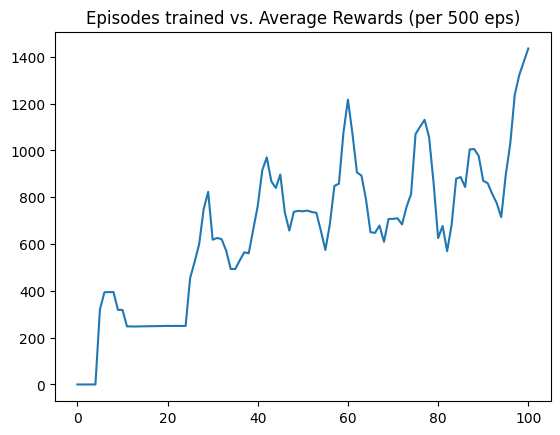

In [7]:
def run(training_mode, pretrained):
   
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = make_env(env)  # Wraps the environment so that frames are grayscale 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dq=True,
                     pretrained=pretrained)
    
    num_episodes = 100
    env.reset()
    total_rewards = []
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)

        print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        num_episodes += 1      
    
    if training_mode:
        with open("ddqn-files/ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)

        with open("ddqn-files/num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        
        with open("ddqn-files/total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        
        if agent.double_dq:
            torch.save(agent.local_net.state_dict(), "ddqn-files/dq1.pt")
            torch.save(agent.target_net.state_dict(), "ddqn-files/dq2.pt")
        
        else:
            torch.save(agent.dqn.state_dict(), "dq.pt")  
        
        torch.save(agent.STATE_MEM,  "ddqn-files/STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ddqn-files/ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "ddqn-files/REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "ddqn-files/STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "ddqn-files/DONE_MEM.pt")
    
    env.close()
    
    if num_episodes > 5:
        plt.title("Episodes trained vs. Average Rewards (per 500 eps)")
        plt.plot([0 for _ in range(5)] + 
                 np.convolve(total_rewards, np.ones((5,))/5, mode="valid").tolist())
        plt.show()

run(training_mode=True, pretrained=False)